In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import sys

sys.path.append("/kvh4/optic_disc/scripts") 
from training import train_dice, train_bce, train_dice_MC, run_inference, run_MC_inference, \
                    run_ensemble_inference
from evaluation_functions import compute_dice_dataset, \
                                    compute_max_softmax_uncertainty_dataset, \
                                    load_pred, \
                                    compute_mean_uncertainty_dataset,  \
                                    compute_mean_pw_dice_dataset

## Generate Dataset Splits
Don't run again

In [2]:
filepath = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training"
with open(os.path.join(filepath, "dataset_splits_nonglaucoma_600_100.pkl"), 'rb') as file:
    data_dict = pickle.load(file)

In [3]:
glaucoma_image_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/images"
glaucoma_images = [os.path.join(glaucoma_image_dir, g) for g in os.listdir(glaucoma_image_dir)]
glaucoma_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"
glaucoma_gt = [os.path.join(glaucoma_gt_dir, g) for g in os.listdir(glaucoma_gt_dir)]

In [4]:
gt_dir_ng ="/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
gt_dir_g = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/glaucoma/ground_truth"

In [5]:
def eval_mean_uncertainty(gt_dir_ng, gt_dir_g, pred_dir_training, pred_dir_test, pred_dir_g, sampling=False):
    evaluation_data_dir = dict() # contains the dice scores and everything from the three datasets 
    
    train_names = [n[-9:-4] for n in os.listdir(pred_dir_training)]
    test_names = [n[-9:-4] for n in os.listdir(pred_dir_test)]
    g_names = [n[-9:-4] for n in os.listdir(pred_dir_g)]
    
    # training data 
    res_train = compute_dice_dataset(train_names, gt_dir_ng, pred_dir_training, mode="cup", sampling=sampling)
    train_dice = np.mean(list(res_train.values()))
    unc_train = compute_mean_uncertainty_dataset(train_names, pred_dir_training, sampling=sampling)
    dice_train = list()
    ms_unc_train = list()
    for k in res_train.keys():
        dice_train.append(res_train[k])
        ms_unc_train.append(unc_train[k])
    evaluation_data_dir["train_dice"] = dice_train
    evaluation_data_dir["train_ms"] = ms_unc_train
    
    # test data 
    res_test = compute_dice_dataset(test_names, gt_dir_ng, pred_dir_test, mode="cup", sampling=sampling)
    test_dice = np.mean(list(res_test.values()))
    unc_test = compute_mean_uncertainty_dataset(test_names, pred_dir_test, sampling=sampling)
    dice_test = list()
    ms_unc_test = list()
    for k in res_test.keys():
        dice_test.append(res_test[k])
        ms_unc_test.append(unc_test[k])
    evaluation_data_dir["test_dice"] = dice_test
    evaluation_data_dir["test_ms"] = ms_unc_test
    
    # glaucoma data 
    res_g = compute_dice_dataset(g_names, gt_dir_g, pred_dir_g, mode="cup", sampling=sampling)
    g_dice = np.mean(list(res_g.values()))
    unc_g = compute_mean_uncertainty_dataset(g_names, pred_dir_g, sampling=sampling)
    dice_g = list()
    ms_unc_g = list()
    for k in res_g.keys():
        dice_g.append(res_g[k])
        ms_unc_g.append(unc_g[k])
    evaluation_data_dir["glaucoma_dice"] = dice_g
    evaluation_data_dir["glaucoma_ms"] = ms_unc_g
    
    plt.scatter(dice_train, ms_unc_train, label="training, "+str(round(train_dice, 3)))
    plt.scatter(dice_test, ms_unc_test, label="test non-glaucoma, "+str(round(test_dice, 3)))
    plt.scatter(dice_g, ms_unc_g, label="test glaucoma, "+str(round(g_dice, 3)))
    
    plt.ylabel("mean uncertainty")
    plt.xlabel("Dice score")
    plt.legend()
    
    return evaluation_data_dir

In [6]:
def eval_mean_pw_dice(gt_dir_ng, gt_dir_g, pred_dir_training, pred_dir_test, pred_dir_g):
    evaluation_data_dir = dict() # contains the dice scores and everything from the three datasets 
    
    train_names = [n[-9:-4] for n in os.listdir(pred_dir_training)]
    test_names = [n[-9:-4] for n in os.listdir(pred_dir_test)]
    g_names = [n[-9:-4] for n in os.listdir(pred_dir_g)]
    
    # training data 
    res_train = compute_dice_dataset(train_names, gt_dir_ng, pred_dir_training, mode="cup", sampling=True)
    train_dice = np.mean(list(res_train.values()))
    unc_train = compute_mean_pw_dice_dataset(train_names, pred_dir_training)
    dice_train = list()
    ms_unc_train = list()
    for k in res_train.keys():
        dice_train.append(res_train[k])
        ms_unc_train.append(unc_train[k])
    evaluation_data_dir["train_dice"] = dice_train
    evaluation_data_dir["train_ms"] = ms_unc_train
    
    # test data 
    res_test = compute_dice_dataset(test_names, gt_dir_ng, pred_dir_test, mode="cup", sampling=True)
    test_dice = np.mean(list(res_test.values()))
    unc_test = compute_mean_pw_dice_dataset(test_names, pred_dir_test)
    dice_test = list()
    ms_unc_test = list()
    for k in res_test.keys():
        dice_test.append(res_test[k])
        ms_unc_test.append(unc_test[k])
    evaluation_data_dir["test_dice"] = dice_test
    evaluation_data_dir["test_ms"] = ms_unc_test
    
    # glaucoma data 
    res_g = compute_dice_dataset(g_names, gt_dir_g, pred_dir_g, mode="cup", sampling=True)
    g_dice = np.mean(list(res_g.values()))
    unc_g = compute_mean_pw_dice_dataset(g_names, pred_dir_g)
    dice_g = list()
    ms_unc_g = list()
    for k in res_g.keys():
        dice_g.append(res_g[k])
        ms_unc_g.append(unc_g[k])
    evaluation_data_dir["glaucoma_dice"] = dice_g
    evaluation_data_dir["glaucoma_ms"] = ms_unc_g
    
    plt.scatter(dice_train, ms_unc_train, label="training, "+str(round(train_dice, 3)))
    plt.scatter(dice_test, ms_unc_test, label="test non-glaucoma, "+str(round(test_dice, 3)))
    plt.scatter(dice_g, ms_unc_g, label="test glaucoma, "+str(round(g_dice, 3)))
    
    plt.ylabel("mean pw Dice")
    plt.xlabel("Dice score")
    plt.legend()
    
    return evaluation_data_dir

# MC dice model

In [92]:
training_params_MC_dice = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 200,
                  "model_dir": "/kvh4/optic_disc/models/04_MC_UNet_cup",
                  "p_dropout": 0.2}

In [93]:
with open(os.path.join(training_params_MC_dice["model_dir"], "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_MC_dice, file)

In [94]:
train_dice_MC(**training_params)

NameError: name 'training_params' is not defined

In [ ]:
train_loss = np.load(os.path.join(training_params_MC_dice["model_dir"], "epoch_loss.npy"))
val_loss = np.load(os.path.join(training_params_MC_dice["model_dir"], "val_loss.npy"))
val_metrics = np.load(os.path.join(training_params_MC_dice["model_dir"], "val_metrics.npy"))

In [ ]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [ ]:
MC_pred_params = {"model_dir": training_params_MC_dice["model_dir"], 
                  "model_epoch": 136, 
                  "test_images":  data_dict["test_images"],
                  "test_gt": data_dict["test_gt"], 
                  "save_dir": os.path.join(training_params_MC_dice["model_dir"], "test_preds_epoch_136"), 
                  "iterations":30,
                  "dropout": .2
                 }

In [ ]:
run_MC_inference(**MC_pred_params)

In [ ]:
pred = np.load(os.path.join(MC_pred_params["save_dir"], "V0382.npy"))
pred.shape

In [ ]:
plt.subplots(1,5, figsize=(20,4))

for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(pred[:,:,i].astype(int))

In [ ]:
pred = load_pred(MC_pred_params["save_dir"], "V0382")

In [ ]:
plt.subplots(2,5, figsize=(20,8))

for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(pred[:,:,i].astype(int))

In [ ]:
mean_pred = np.mean(binarize_pred(pred), axis=2)

In [ ]:
mean_pred.shape

In [ ]:
plt.imshow(binarize_pred(mean_pred))

In [ ]:
plt.imshow(generate_voxelwise_uncertainty(pred))

In [ ]:
test_names = [n[-9:-4] for n in data_dict["test_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
MC_dice = compute_dice_dataset(test_names, ng_gt_dir, MC_pred_params["save_dir"], mode="cup", sampling=True)
MC_unc = compute_mean_uncertainty_dataset(test_names, MC_pred_params["save_dir"], sampling=True)

In [ ]:
np.mean(list(MC_dice.values()))

In [ ]:
dice = list()
ms_unc = list()
for k in MC_dice.keys():
    dice.append(MC_dice[k])
    ms_unc.append(MC_unc[k])

In [ ]:
plt.scatter(dice, ms_unc)

## MC dropout 
#### p_dr = .1

In [ ]:
training_params_MC_dice = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 200,
                  "model_dir": "/kvh4/optic_disc/models/09_MC_UNet_p10_cup",
                  "p_dropout": 0.1}

In [ ]:
with open(os.path.join(training_params_MC_dice["model_dir"], "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_MC_dice, file)

In [ ]:
train_dice_MC(**training_params_MC_dice)

In [ ]:
train_loss = np.load(os.path.join(training_params_MC_dice["model_dir"], "epoch_loss.npy"))
val_loss = np.load(os.path.join(training_params_MC_dice["model_dir"], "val_loss.npy"))
val_metrics = np.load(os.path.join(training_params_MC_dice["model_dir"], "val_metrics.npy"))

In [ ]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

#### evaluate at epoch 150 with 30 samples

In [ ]:
MC_pred_params_test = {"model_dir": training_params_MC_dice["model_dir"], 
                  "model_epoch": 150, 
                  "test_images":  data_dict["test_images"],
                  "test_gt": data_dict["test_gt"], 
                  "save_dir": os.path.join(training_params_MC_dice["model_dir"], "test_preds_epoch_150"), 
                  "iterations":30,
                  "dropout": .1
                 }

run_MC_inference(**MC_pred_params_test)

In [ ]:
test_names = [n[-9:-4] for n in data_dict["test_images"]]
ng_gt_dir = "/kvh4/optic_disc/data/REFUGE-2/REFUGE2-Training/resized_data/non_glaucoma/ground_truth"
MC_dice = compute_dice_dataset(test_names, ng_gt_dir, MC_pred_params["save_dir"], mode="cup", sampling=True)
MC_unc = compute_mean_uncertainty_dataset(test_names, MC_pred_params["save_dir"], sampling=True)

In [ ]:
np.mean(list(MC_dice.values()))

In [ ]:
dice = list()
ms_unc = list()
for k in MC_dice.keys():
    dice.append(MC_dice[k])
    ms_unc.append(MC_unc[k])

In [ ]:
plt.scatter(dice, ms_unc)
plt.xlabel("Dice score")
plt.ylabel("mean uncertainty")
plt.title("MC dropout, p=.1, 30 samples, test set")

## no dropout 
### seed = 0 

In [96]:
training_params_0 = {"seed": 0, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/05_UNet_cup_s0",
                  "p_dropout": 0.0}

In [ ]:
train_dice(**training_params_0)

In [98]:
# filepath = training_params_0["model_dir"]
filepath = "/kvh4/optic_disc/models/dice_ensemble/00_UNet_cup"# new filepatch 
train_loss = np.load(os.path.join(filepath, "epoch_loss.npy"))
val_loss = np.load(os.path.join(filepath, "val_loss.npy"))
val_metrics = np.load(os.path.join(filepath, "val_metrics.npy"))

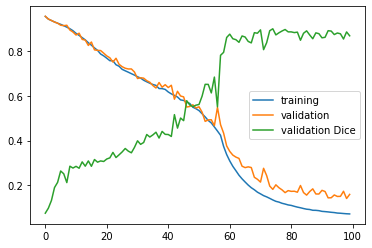

In [99]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

#### choose epoch 80 for evaluation
##### test data
based on val loss flattening around this time

In [100]:
inference_parameters_test_0 = {"model_dir": training_params_0["model_dir"], 
                         "model_epoch": 80,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_0["model_dir"], "test_pred_epoch_80")}

In [ ]:
run_inference(**inference_parameters_test_0)

In [101]:
inference_parameters_train_0 = {"model_dir": training_params_0["model_dir"], 
                         "model_epoch": 80,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_0["model_dir"], "training_pred_epoch_80")}

In [ ]:
run_inference(**inference_parameters_train_0)

In [102]:
inference_parameters_glaucoma_0 = {"model_dir": training_params_0["model_dir"], 
                         "model_epoch": 80,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_0["model_dir"], "glaucoma_pred_epoch_80")}

In [ ]:
run_inference(**inference_parameters_glaucoma_0)

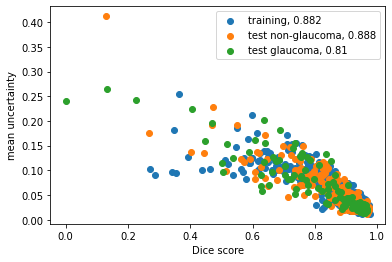

In [103]:
model_dir = training_params_0["model_dir"]
eval_dict_0 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_80"),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_80"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_80"), 
             "sampling": False}

dice_seed_0_eval = eval_mean_uncertainty(**eval_dict_0)

## seed = 1

In [104]:
training_params_1 = {"seed": 1, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/01_UNet_cup",
                  "p_dropout": 0.0}

In [105]:
model_path = training_params_1["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_1, file)

In [ ]:
train_dice(**training_params_1)

In [106]:
model_path = training_params_1["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

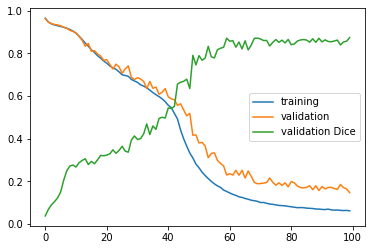

In [107]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [108]:
inference_parameters_training_1 = {"model_dir": training_params_1["model_dir"], 
                         "model_epoch": 70,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_1["model_dir"], "training_pred_epoch_70")}

In [ ]:
run_inference(**inference_parameters_training_1)

In [109]:
inference_parameters_test_1 = {"model_dir": training_params_1["model_dir"], 
                         "model_epoch": 70,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_1["model_dir"], "test_pred_epoch_70")}

In [ ]:
run_inference(**inference_parameters_test_1)

In [110]:
inference_parameters_glaucoma_1 = {"model_dir": training_params_1["model_dir"], 
                         "model_epoch": 70,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_1["model_dir"], "glaucoma_pred_epoch_70")}

In [ ]:
run_inference(**inference_parameters_glaucoma_1)

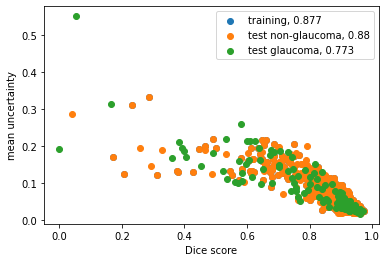

In [111]:
model_dir = training_params_1["model_dir"]
eval_dict_1 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_70"),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_70"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_70"), 
             "sampling": False}

dice_seed_1_eval = eval_mean_uncertainty(**eval_dict_1)

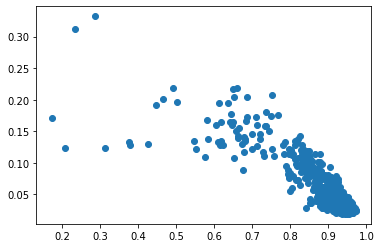

In [135]:
plt.scatter(dice_seed_1_eval["train_dice"], dice_seed_1_eval["train_ms"])

### seed = 2

In [112]:
training_params_2 = {"seed": 2, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/02_UNet_cup",
                  "p_dropout": 0.0}

In [153]:
model_path = training_params_2["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_2, file)

In [ ]:
train_dice(**training_params_2)

In [114]:
model_path = training_params_2["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

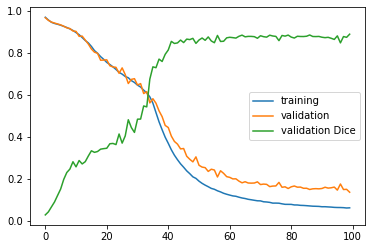

In [115]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [116]:
inference_parameters_training_2 = {"model_dir": training_params_2["model_dir"], 
                         "model_epoch": 75,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_2["model_dir"], "training_pred_epoch_75")}

In [ ]:
run_inference(**inference_parameters_training_2)

In [117]:
inference_parameters_test_2 = {"model_dir": training_params_2["model_dir"], 
                         "model_epoch": 75,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_2["model_dir"], "test_pred_epoch_75")}

In [ ]:
run_inference(**inference_parameters_test_2)

In [118]:
inference_parameters_glaucoma_2 = {"model_dir": training_params_2["model_dir"], 
                         "model_epoch": 75,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_2["model_dir"], "glaucoma_pred_epoch_75")}

In [ ]:
run_inference(**inference_parameters_glaucoma_2)

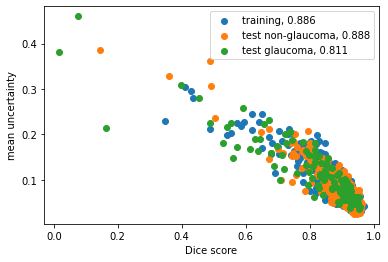

In [119]:
model_dir = training_params_2["model_dir"]
eval_dict_2 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_75"),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_75"), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_75"), 
             "sampling": False}

dice_seed_2_eval = eval_mean_uncertainty(**eval_dict_2)

### seed = 3

In [120]:
training_params_3 = {"seed": 3, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/03_UNet_cup",
                  "p_dropout": 0.0}

In [152]:
model_path = training_params_3["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_3, file)

In [122]:
train_dice(**training_params_3)

----------
epoch 1/100
epoch 1 average loss: 0.9617
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_1.pth
saved model


y_pred has only one channel, include_background=False ignored.


current epoch: 1 current mean dice: 0.0401
val loss:  0.960666942000389
----------
epoch 2/100
epoch 2 average loss: 0.9543
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0514
val loss:  0.9539261996746063
----------
epoch 3/100
epoch 3 average loss: 0.9496
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.0593
val loss:  0.95093570291996
----------
epoch 4/100
epoch 4 average loss: 0.9452
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.0748
val loss:  0.9464247381687164
----------
epoch 5/100
epoch 5 average loss: 0.9407
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.1197
val loss:  0.9426384192705154
----------
epoch 6/100
epoch 6 average loss: 0.9366
savepath:  /kvh4/optic_disc/models/dic

current epoch: 40 current mean dice: 0.4542
val loss:  0.6238582235574722
----------
epoch 41/100
epoch 41 average loss: 0.6055
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_41.pth
saved model
current epoch: 41 current mean dice: 0.4663
val loss:  0.6297037452459335
----------
epoch 42/100
epoch 42 average loss: 0.5897
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_42.pth
saved model
current epoch: 42 current mean dice: 0.5091
val loss:  0.6199071884155274
----------
epoch 43/100
epoch 43 average loss: 0.5836
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_43.pth
saved model
current epoch: 43 current mean dice: 0.4897
val loss:  0.602655953168869
----------
epoch 44/100
epoch 44 average loss: 0.5733
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_44.pth
saved model
current epoch: 44 current mean dice: 0.4806
val loss:  0.6088080132007598
----------
epoch 45/100
epoch 45 average loss: 0.5596
savepath:  /kvh4/

epoch 79 average loss: 0.0965
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_79.pth
saved model
current epoch: 79 current mean dice: 0.8830
val loss:  0.1701397854089737
----------
epoch 80/100
epoch 80 average loss: 0.0943
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_80.pth
saved model
current epoch: 80 current mean dice: 0.8612
val loss:  0.18618044674396514
----------
epoch 81/100
epoch 81 average loss: 0.0969
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_81.pth
saved model
current epoch: 81 current mean dice: 0.8738
val loss:  0.17467862546443938
----------
epoch 82/100
epoch 82 average loss: 0.0898
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_82.pth
saved model
current epoch: 82 current mean dice: 0.8827
val loss:  0.16188450872898102
----------
epoch 83/100
epoch 83 average loss: 0.0885
savepath:  /kvh4/optic_disc/models/dice_ensemble/03_UNet_cup/epoch_83.pth
saved model
current epoch: 83 current

In [123]:
model_path = training_params_3["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

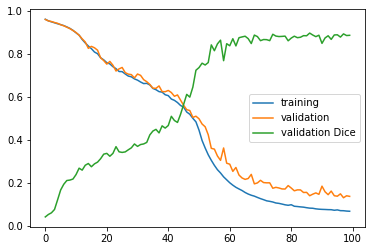

In [126]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.legend()

In [127]:
eval_epoch_3 = 87

In [128]:
inference_parameters_training_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_3))}

In [129]:
run_inference(**inference_parameters_training_3)

finished inference


In [130]:
inference_parameters_test_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_3))}

In [131]:
run_inference(**inference_parameters_test_3)

finished inference


In [132]:
inference_parameters_glaucoma_3 = {"model_dir": training_params_3["model_dir"], 
                         "model_epoch": eval_epoch_3,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_3["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_3))}

In [133]:
run_inference(**inference_parameters_glaucoma_3)

finished inference


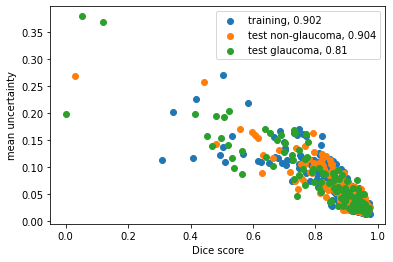

In [134]:
model_dir = training_params_3["model_dir"]
eval_dict_3 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_3)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_3)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_3)), 
             "sampling": False}

dice_seed_3_eval = eval_mean_uncertainty(**eval_dict_3)

### seed = 4

In [136]:
training_params_4 = {"seed": 4, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/04_UNet_cup",
                  "p_dropout": 0.0}

In [151]:
model_path = training_params_4["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_4, file)

In [138]:
train_dice(**training_params_4)

----------
epoch 1/100
epoch 1 average loss: 0.9582
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_1.pth
saved model


y_pred has only one channel, include_background=False ignored.


current epoch: 1 current mean dice: 0.0913
val loss:  0.9606021744012833
----------
epoch 2/100
epoch 2 average loss: 0.9456
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0997
val loss:  0.945530698299408
----------
epoch 3/100
epoch 3 average loss: 0.9386
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.1358
val loss:  0.9399954152107238
----------
epoch 4/100
epoch 4 average loss: 0.9343
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1823
val loss:  0.9369518476724624
----------
epoch 5/100
epoch 5 average loss: 0.9312
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.2129
val loss:  0.9343438082933426
----------
epoch 6/100
epoch 6 average loss: 0.9284
savepath:  /kvh4/optic_disc/models/d

current epoch: 40 current mean dice: 0.4253
val loss:  0.6612584805488586
----------
epoch 41/100
epoch 41 average loss: 0.6318
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_41.pth
saved model
current epoch: 41 current mean dice: 0.4301
val loss:  0.6582589936256409
----------
epoch 42/100
epoch 42 average loss: 0.6199
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_42.pth
saved model
current epoch: 42 current mean dice: 0.4559
val loss:  0.6418362456560135
----------
epoch 43/100
epoch 43 average loss: 0.6113
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_43.pth
saved model
current epoch: 43 current mean dice: 0.5421
val loss:  0.5915801548957824
----------
epoch 44/100
epoch 44 average loss: 0.6041
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_44.pth
saved model
current epoch: 44 current mean dice: 0.4701
val loss:  0.6242904299497605
----------
epoch 45/100
epoch 45 average loss: 0.5949
savepath:  /kvh4

epoch 79 average loss: 0.1184
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_79.pth
saved model
current epoch: 79 current mean dice: 0.8323
val loss:  0.23308429956436158
----------
epoch 80/100
epoch 80 average loss: 0.1152
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_80.pth
saved model
current epoch: 80 current mean dice: 0.8382
val loss:  0.22445497214794158
----------
epoch 81/100
epoch 81 average loss: 0.1112
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_81.pth
saved model
current epoch: 81 current mean dice: 0.8062
val loss:  0.24699480652809144
----------
epoch 82/100
epoch 82 average loss: 0.1075
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_82.pth
saved model
current epoch: 82 current mean dice: 0.8561
val loss:  0.20294968605041505
----------
epoch 83/100
epoch 83 average loss: 0.1033
savepath:  /kvh4/optic_disc/models/dice_ensemble/04_UNet_cup/epoch_83.pth
saved model
current epoch: 83 curren

In [139]:
model_path = training_params_4["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

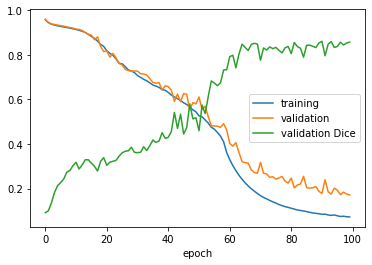

In [140]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [141]:
eval_epoch_4 = 91

In [142]:
inference_parameters_training_4 = {"model_dir": training_params_4["model_dir"], 
                         "model_epoch": eval_epoch_4,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_4["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_4))}

In [143]:
run_inference(**inference_parameters_training_4)

finished inference


In [144]:
inference_parameters_test_4 = {"model_dir": training_params_4["model_dir"], 
                         "model_epoch": eval_epoch_4,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_4["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_4))}

In [145]:
run_inference(**inference_parameters_test_4)

finished inference


In [146]:
inference_parameters_glaucoma_4 = {"model_dir": training_params_4["model_dir"], 
                         "model_epoch": eval_epoch_4,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_4["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_4))}

In [147]:
run_inference(**inference_parameters_glaucoma_4)

finished inference


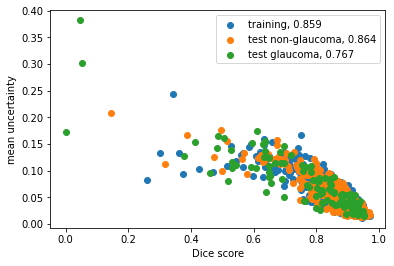

In [148]:
model_dir = training_params_4["model_dir"]
eval_dict_4 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_4)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_4)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_4)), 
             "sampling": False}

dice_seed_4_eval = eval_mean_uncertainty(**eval_dict_4)

### seed = 5

In [ ]:
training_params_5 = {"seed": 5, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/05_UNet_cup",
                  "p_dropout": 0.0}

In [150]:
model_path = training_params_5["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_5, file)

In [154]:
train_dice(**training_params_5)

----------
epoch 1/100
epoch 1 average loss: 0.9522
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_1.pth
saved model


y_pred has only one channel, include_background=False ignored.


current epoch: 1 current mean dice: 0.0898
val loss:  0.9528392606973648
----------
epoch 2/100
epoch 2 average loss: 0.9414
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0995
val loss:  0.9417003256082535
----------
epoch 3/100
epoch 3 average loss: 0.9347
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.1287
val loss:  0.9362436532974243
----------
epoch 4/100
epoch 4 average loss: 0.9303
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.1595
val loss:  0.9313601422309875
----------
epoch 5/100
epoch 5 average loss: 0.9260
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_5.pth
saved model
current epoch: 5 current mean dice: 0.1924
val loss:  0.9265272301435471
----------
epoch 6/100
epoch 6 average loss: 0.9216
savepath:  /kvh4/optic_disc/models/

epoch 40 average loss: 0.5876
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_40.pth
saved model
current epoch: 40 current mean dice: 0.5154
val loss:  0.5997953754663468
----------
epoch 41/100
epoch 41 average loss: 0.5790
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_41.pth
saved model
current epoch: 41 current mean dice: 0.4824
val loss:  0.6167822003364563
----------
epoch 42/100
epoch 42 average loss: 0.5667
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_42.pth
saved model
current epoch: 42 current mean dice: 0.5827
val loss:  0.5611670035123825
----------
epoch 43/100
epoch 43 average loss: 0.5525
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_43.pth
saved model
current epoch: 43 current mean dice: 0.5518
val loss:  0.5687727284431457
----------
epoch 44/100
epoch 44 average loss: 0.5399
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_44.pth
saved model
current epoch: 44 current me

current epoch: 78 current mean dice: 0.8478
val loss:  0.19893278300762177
----------
epoch 79/100
epoch 79 average loss: 0.0952
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_79.pth
saved model
current epoch: 79 current mean dice: 0.8837
val loss:  0.16323828876018523
----------
epoch 80/100
epoch 80 average loss: 0.0928
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_80.pth
saved model
current epoch: 80 current mean dice: 0.8793
val loss:  0.16660306870937347
----------
epoch 81/100
epoch 81 average loss: 0.0894
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_81.pth
saved model
current epoch: 81 current mean dice: 0.8686
val loss:  0.17636143743991853
----------
epoch 82/100
epoch 82 average loss: 0.0888
savepath:  /kvh4/optic_disc/models/dice_ensemble/05_UNet_cup/epoch_82.pth
saved model
current epoch: 82 current mean dice: 0.8698
val loss:  0.172942795753479
----------
epoch 83/100
epoch 83 average loss: 0.0872
savepath:  /k

In [172]:
model_path = training_params_5["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

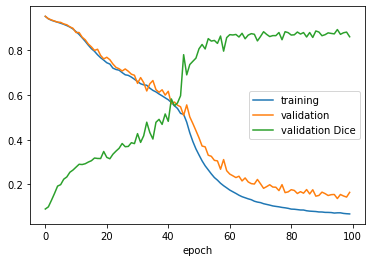

In [173]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [179]:
eval_epoch_5 = 89

In [180]:
inference_parameters_training_5 = {"model_dir": training_params_5["model_dir"], 
                         "model_epoch": eval_epoch_5,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_5["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_5))}

In [181]:
run_inference(**inference_parameters_training_5)

finished inference


In [182]:
inference_parameters_test_5 = {"model_dir": training_params_5["model_dir"], 
                         "model_epoch": eval_epoch_5,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_5["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_5))}

In [183]:
run_inference(**inference_parameters_test_5)

finished inference


In [184]:
inference_parameters_glaucoma_5 = {"model_dir": training_params_5["model_dir"], 
                         "model_epoch": eval_epoch_5,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_5["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_5))}

In [185]:
run_inference(**inference_parameters_glaucoma_5)

finished inference


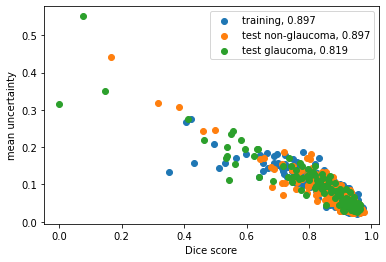

In [186]:
model_dir = training_params_5["model_dir"]
eval_dict_5 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_5)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_5)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_5)), 
             "sampling": False}

dice_seed_5_eval = eval_mean_uncertainty(**eval_dict_5)

### seed = 6

In [155]:
training_params_6 = {"seed": 6, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/06_UNet_cup",
                  "p_dropout": 0.0}

In [156]:
model_path = training_params_6["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_6, file)

In [ ]:
train_dice(**training_params_6)

----------
epoch 1/100
epoch 1 average loss: 0.9624
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_1.pth
saved model
current epoch: 1 current mean dice: 0.0442
val loss:  0.9611746865510941
----------
epoch 2/100
epoch 2 average loss: 0.9451
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_2.pth
saved model
current epoch: 2 current mean dice: 0.0667
val loss:  0.945847687125206
----------
epoch 3/100
epoch 3 average loss: 0.9391
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_3.pth
saved model
current epoch: 3 current mean dice: 0.0811
val loss:  0.9423702538013459
----------
epoch 4/100
epoch 4 average loss: 0.9351
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_4.pth
saved model
current epoch: 4 current mean dice: 0.0892
val loss:  0.9382497864961624
----------
epoch 5/100
epoch 5 average loss: 0.9315
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_5.pth
saved model
current epoch: 5 current

current epoch: 39 current mean dice: 0.7216
val loss:  0.5293931990861893
----------
epoch 40/100
epoch 40 average loss: 0.4422
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_40.pth
saved model
current epoch: 40 current mean dice: 0.8237
val loss:  0.4721173596382141
----------
epoch 41/100
epoch 41 average loss: 0.4010
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_41.pth
saved model
current epoch: 41 current mean dice: 0.8489
val loss:  0.43465376675128936
----------
epoch 42/100
epoch 42 average loss: 0.3683
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_42.pth
saved model
current epoch: 42 current mean dice: 0.8350
val loss:  0.4120078933238983
----------
epoch 43/100
epoch 43 average loss: 0.3386
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_43.pth
saved model
current epoch: 43 current mean dice: 0.8723
val loss:  0.3752520728111267
----------
epoch 44/100
epoch 44 average loss: 0.3108
savepath:  /kvh

epoch 78 average loss: 0.0780
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_78.pth
saved model
current epoch: 78 current mean dice: 0.8748
val loss:  0.15562854528427125
----------
epoch 79/100
epoch 79 average loss: 0.0774
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_79.pth
saved model
current epoch: 79 current mean dice: 0.8754
val loss:  0.15439850091934204
----------
epoch 80/100
epoch 80 average loss: 0.0757
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_80.pth
saved model
current epoch: 80 current mean dice: 0.8444
val loss:  0.1821012282371521
----------
epoch 81/100
epoch 81 average loss: 0.0748
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_81.pth
saved model
current epoch: 81 current mean dice: 0.8209
val loss:  0.20228758513927458
----------
epoch 82/100
epoch 82 average loss: 0.0776
savepath:  /kvh4/optic_disc/models/dice_ensemble/06_UNet_cup/epoch_82.pth
saved model
current epoch: 82 current

In [187]:
model_path = training_params_6["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

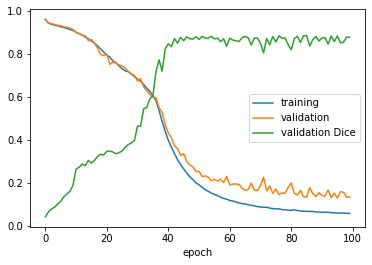

In [188]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [189]:
eval_epoch_6 = 77

In [190]:
inference_parameters_training_6 = {"model_dir": training_params_6["model_dir"], 
                         "model_epoch": eval_epoch_6,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_6["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_6))}

In [191]:
run_inference(**inference_parameters_training_6)

finished inference


In [192]:
inference_parameters_test_6 = {"model_dir": training_params_6["model_dir"], 
                         "model_epoch": eval_epoch_6,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_6["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_6))}

In [193]:
run_inference(**inference_parameters_test_6)

finished inference


In [194]:
inference_parameters_glaucoma_6 = {"model_dir": training_params_6["model_dir"], 
                         "model_epoch": eval_epoch_6,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_6["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_6))}

In [195]:
run_inference(**inference_parameters_glaucoma_6)

finished inference


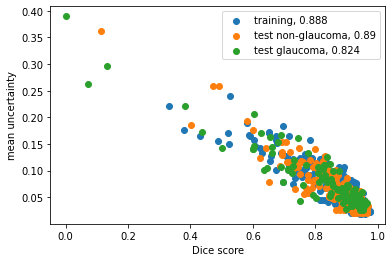

In [196]:
model_dir = training_params_6["model_dir"]
eval_dict_6 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_6)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_6)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_6)), 
             "sampling": False}

dice_seed_6_eval = eval_mean_uncertainty(**eval_dict_6)

### seed = 7

In [ ]:
training_params_7 = {"seed": 7, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/07_UNet_cup",
                  "p_dropout": 0.0}

In [ ]:
model_path = training_params_7["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_7, file)

In [ ]:
train_dice(**training_params_7)

In [197]:
model_path = training_params_7["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

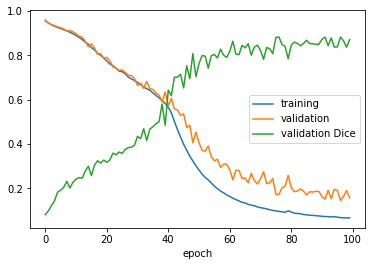

In [198]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [201]:
eval_epoch_7 = 77

In [202]:
inference_parameters_training_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_7))}

In [203]:
run_inference(**inference_parameters_training_7)

finished inference


In [204]:
inference_parameters_test_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_7))}

In [205]:
run_inference(**inference_parameters_test_7)

finished inference


In [206]:
inference_parameters_glaucoma_7 = {"model_dir": training_params_7["model_dir"], 
                         "model_epoch": eval_epoch_7,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_7["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_7))}

In [207]:
run_inference(**inference_parameters_glaucoma_7)

finished inference


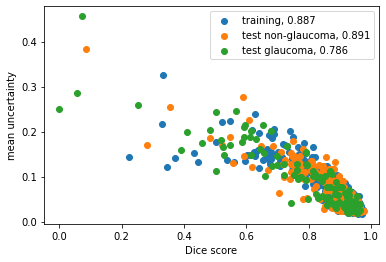

In [208]:
model_dir = training_params_7["model_dir"]
eval_dict_7 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_7)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_7)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_7)), 
             "sampling": False}

dice_seed_7_eval = eval_mean_uncertainty(**eval_dict_7)

### seed = 8

In [ ]:
training_params_8 = {"seed": 8, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/08_UNet_cup",
                  "p_dropout": 0.0}

In [ ]:
model_path = training_params_8["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_8, file)

In [ ]:
train_dice(**training_params_8)

In [209]:
model_path = training_params_8["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

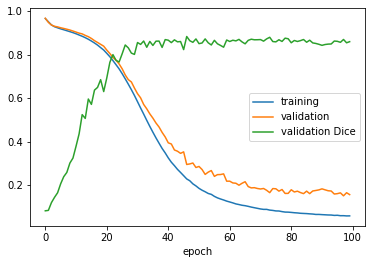

In [210]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [213]:
eval_epoch_8 = 74

In [214]:
inference_parameters_training_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_8))}

In [215]:
run_inference(**inference_parameters_training_8)

finished inference


In [216]:
inference_parameters_test_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_8))}

In [217]:
run_inference(**inference_parameters_test_8)

finished inference


In [218]:
inference_parameters_glaucoma_8 = {"model_dir": training_params_8["model_dir"], 
                         "model_epoch": eval_epoch_8,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_8["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_8))}

In [219]:
run_inference(**inference_parameters_glaucoma_8)

finished inference


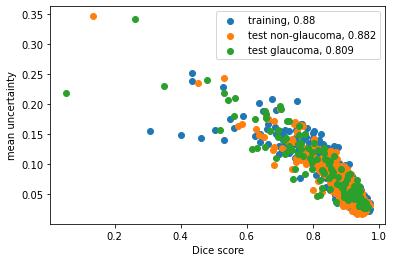

In [220]:
model_dir = training_params_8["model_dir"]
eval_dict_8 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_8)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_8)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_8)), 
             "sampling": False}

dice_seed_8_eval = eval_mean_uncertainty(**eval_dict_8)

### seed = 9

In [ ]:
training_params_9 = {"seed": 9, 
                   "training_images": data_dict["training_images"],
                  "training_gt": data_dict["training_gt"], 
                  "validation_images": data_dict["validation_images"],
                  "validation_gt": data_dict["validation_gt"],
                  "epoch_num": 100,
                  "model_dir": "/kvh4/optic_disc/models/dice_ensemble/09_UNet_cup",
                  "p_dropout": 0.0}

In [ ]:
model_path = training_params_9["model_dir"]
if not os.path.exists(model_path):
    os.makedirs(model_path)
    
with open(os.path.join(model_path, "training_params.pkl"), 'wb') as file:
      
    # A new file will be created
    pickle.dump(training_params_9, file)

In [ ]:
train_dice(**training_params_9)

In [221]:
model_path = training_params_9["model_dir"]

train_loss = np.load(os.path.join(model_path, "epoch_loss.npy"))
val_loss = np.load(os.path.join(model_path, "val_loss.npy"))
val_metrics = np.load(os.path.join(model_path, "val_metrics.npy"))

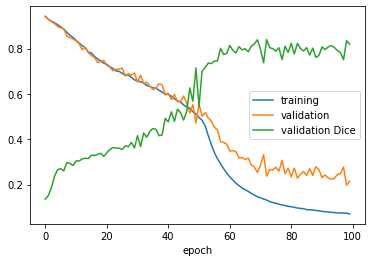

In [222]:
plt.plot(train_loss, label="training")
plt.plot(val_loss, label="validation")
plt.plot(val_metrics, label="validation Dice")
plt.xlabel("epoch")
plt.legend()

In [224]:
eval_epoch_9 = 73

In [225]:
inference_parameters_training_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": data_dict["training_images"],
                         "test_gt": data_dict["training_gt"], 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "training_pred_epoch_"+str(eval_epoch_9))}

In [226]:
run_inference(**inference_parameters_training_9)

finished inference


In [227]:
inference_parameters_test_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": data_dict["test_images"],
                         "test_gt": data_dict["test_gt"], 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "test_pred_epoch_"+str(eval_epoch_9))}

In [228]:
run_inference(**inference_parameters_test_9)

finished inference


In [229]:
inference_parameters_glaucoma_9 = {"model_dir": training_params_9["model_dir"], 
                         "model_epoch": eval_epoch_9,
                         "test_images": glaucoma_images,
                         "test_gt": glaucoma_gt, 
                         "save_dir": os.path.join(training_params_9["model_dir"], \
                                                  "glaucoma_pred_epoch_"+str(eval_epoch_9))}

In [230]:
run_inference(**inference_parameters_glaucoma_9)

finished inference


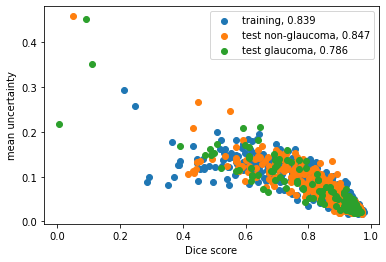

In [231]:
model_dir = training_params_9["model_dir"]
eval_dict_9 = {"gt_dir_ng": gt_dir_ng,
             "gt_dir_g": gt_dir_g, 
             "pred_dir_training": os.path.join(model_dir, "training_pred_epoch_"+str(eval_epoch_9)),
             "pred_dir_test": os.path.join(model_dir, "test_pred_epoch_"+str(eval_epoch_9)), 
             "pred_dir_g": os.path.join(model_dir, "glaucoma_pred_epoch_"+str(eval_epoch_9)), 
             "sampling": False}

dice_seed_9_eval = eval_mean_uncertainty(**eval_dict_9)

## ensemble inference 

In [16]:
ensemble_inference_params_test = {"ensemble_dir": "/kvh4/optic_disc/models/dice_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_80.pth", "01_UNet_cup/epoch_70.pth",
                                               "02_UNet_cup/epoch_75.pth", "03_UNet_cup/epoch_87.pth",
                                               "04_UNet_cup/epoch_91.pth", "05_UNet_cup/epoch_89.pth",
                                               "06_UNet_cup/epoch_77.pth", "07_UNet_cup/epoch_77.pth",
                                               "08_UNet_cup/epoch_74.pth", "09_UNet_cup/epoch_73.pth"],
                            "test_images": data_dict["test_images"],
                            "test_gt": data_dict["test_gt"],
                            "save_dir": "/kvh4/optic_disc/models/dice_ensemble/test_pred"}

run_ensemble_inference(**ensemble_inference_params_test)

finished inference


In [13]:
ensemble_inference_params_training = {"ensemble_dir": "/kvh4/optic_disc/models/dice_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_80.pth", "01_UNet_cup/epoch_70.pth",
                                               "02_UNet_cup/epoch_75.pth", "03_UNet_cup/epoch_87.pth",
                                               "04_UNet_cup/epoch_91.pth", "05_UNet_cup/epoch_89.pth",
                                               "06_UNet_cup/epoch_77.pth", "07_UNet_cup/epoch_77.pth",
                                               "08_UNet_cup/epoch_74.pth", "09_UNet_cup/epoch_73.pth"],
                            "test_images": data_dict["training_images"],
                            "test_gt": data_dict["training_gt"],
                            "save_dir": "/kvh4/optic_disc/models/dice_ensemble/training_pred"}

run_ensemble_inference(**ensemble_inference_params_training)

finished inference


In [15]:
ensemble_inference_params_glaucoma = {"ensemble_dir": "/kvh4/optic_disc/models/dice_ensemble",
                            "model_name_list": ["00_UNet_cup/epoch_80.pth", "01_UNet_cup/epoch_70.pth",
                                               "02_UNet_cup/epoch_75.pth", "03_UNet_cup/epoch_87.pth",
                                               "04_UNet_cup/epoch_91.pth", "05_UNet_cup/epoch_89.pth",
                                               "06_UNet_cup/epoch_77.pth", "07_UNet_cup/epoch_77.pth",
                                               "08_UNet_cup/epoch_74.pth", "09_UNet_cup/epoch_73.pth"],
                            "test_images": glaucoma_images,
                            "test_gt": glaucoma_gt,
                            "save_dir": "/kvh4/optic_disc/models/dice_ensemble/glaucoma_pred"}

run_ensemble_inference(**ensemble_inference_params_glaucoma)

finished inference


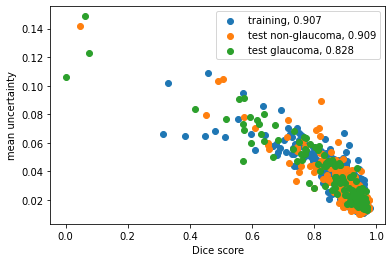

In [20]:
eval_dict_ensemble = {"gt_dir_ng": gt_dir_ng, 
                      "gt_dir_g": gt_dir_g,  
                      "pred_dir_training": "/kvh4/optic_disc/models/dice_ensemble/training_pred",
                      "pred_dir_test": "/kvh4/optic_disc/models/dice_ensemble/test_pred", 
                      "pred_dir_g": "/kvh4/optic_disc/models/dice_ensemble/glaucoma_pred", 
                      "sampling":True
                     }
dice_ensemble_eval = eval_mean_uncertainty(**eval_dict_ensemble)

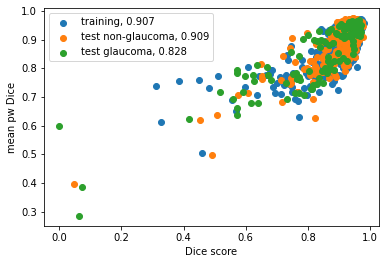

In [7]:
eval_dict_ensemble = {"gt_dir_ng": gt_dir_ng, 
                      "gt_dir_g": gt_dir_g,  
                      "pred_dir_training": "/kvh4/optic_disc/models/dice_ensemble/training_pred",
                      "pred_dir_test": "/kvh4/optic_disc/models/dice_ensemble/test_pred", 
                      "pred_dir_g": "/kvh4/optic_disc/models/dice_ensemble/glaucoma_pred",
                     }
dice_ensemble_eval = eval_mean_pw_dice(**eval_dict_ensemble)